# Intelligente systemer: Klassifisering

Velkommen til denne notebooken som inngår i Høyskolen Kristianias emne «Utvikling og anvendelse av intelligente systemer», modul 2, «Veiledet læring».

## Hvordan du bruker denne notebooken
Dette er en Jupyter notebook med tekst og Python-kode som du kjører ved å trykke shift-enter. Hensikten er å bli kjent med relevante konsepter i praksis, ikke nødvendigvis å forstå alle detaljer i koden. Ta deg god tid til å lese teksten, se gjennom koden, kjøre kodecellene (pass på riktig rekkefølge), studere resultatene, og tenke gjennom hva vi gjør, hvorfor og hvordan.

Underveis i teksten vil du finne referanser til Canvas-oppgaver _i kursiv_. Gå til Canvas og besvar spørsmålene der før du går videre i notebooken.

## Problemstilling: Klassifisering av brystkreft-celleprøver
Vi skal trene en modell til å skjelne mellom ondartede og godartede brystkreft-celleprøver. Dette er et klassisk multi-label klassifiseringsproblem.


In [1]:
#Import relevant packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets  # scikit-learn dataset library
from sklearn.model_selection import train_test_split  # train_test_split function
from sklearn import svm  # svm model
from sklearn import metrics  # scikit-learn metrics module for accuracy calculation

In [2]:
def make_histogram(data, variable, binwidth=None, lower_lim=None, upper_lim=None):
    if upper_lim == None:
        upper_lim = data[variable].max()
    if lower_lim == None:
        lower_lim=data[variable].min()
    if binwidth != None:
        bins = np.arange(lower_lim, upper_lim+binwidth, binwidth)
    else:
        bins = None
    plt.hist(data[variable], bins=bins, edgecolor='black', alpha=0.75, range=[data[variable].min(), upper_lim])
    plt.ylabel("antall")
    plt.xlabel(variable)
    plt.show()

## Data
Til å bygge modellen bruker vi et standard-datasett fra scikit-learn, nemlig brystkreft-datasettet. Dette datasettet beskriver ulike karakteristika ved cellekjerner i brystvev.

Datasettet har 30 features: mean radius, mean texture, mean perimeter, mean area, mean smoothness, mean compactness, mean concavity, mean concave points, mean symmetry, mean fractal dimension, radius error, texture error, perimeter error, area error, smoothness error, compactness error, concavity error, concave points error, symmetry error, fractal dimension error, worst radius, worst texture, worst perimeter, worst area, worst smoothness, worst compactness, worst concavity, worst concave points, worst symmetry, worst fractal dimension og type of cancer.

Sistnevnte, dvs. type of cancer, angir hvilken type kreft prøven stammer fra. Det er to klasser, ondartet (harmful) og godartet (not harmful), og modellen vår skal trenes til å skjelne mellom disse to typene.

Vi følger eksempelet og forklaringen fra https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python. Se gjerne lenken for flere detaljer.

Vi skal benytte metoden støttevektormaskiner (support vector machines, SVM) som du kan lese mer om på https://scikit-learn.org/stable/modules/svm.html.

### Laste inn og utforske dataene

In [3]:
#Load dataset
cancer = datasets.load_breast_cancer()

#Data is loaded as a dictionary but is easier to work with as a pandas data frame. We define a function to convert between the two
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

#And apply it
df = sklearn_to_df(cancer)

In [4]:
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


Disse dataene er allerede pre-prosseserte. Ved å plotte histogrammer av de ulike variablene, vil vi se at outliers, urealistiske verdier osv. er fjernet. Merk at ondartet har annotasjonen 0 og godartet 1.

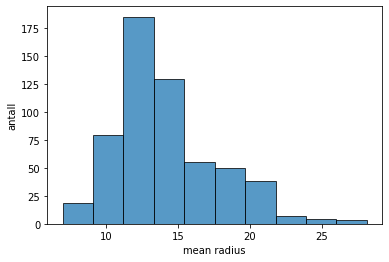

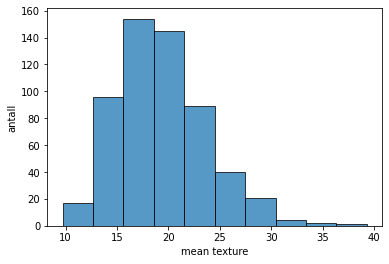

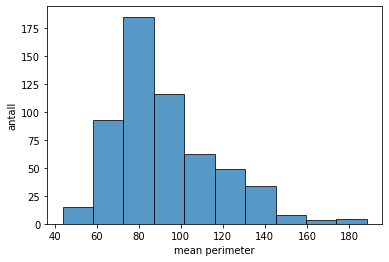

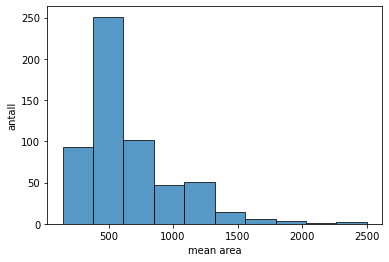

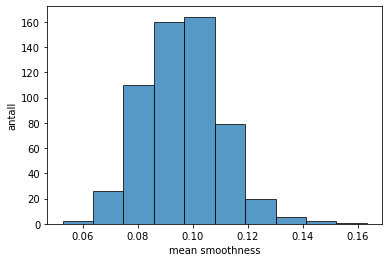

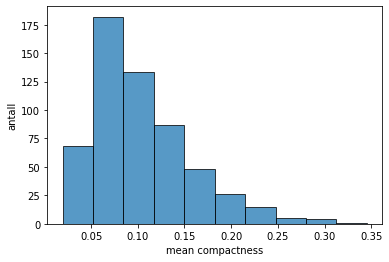

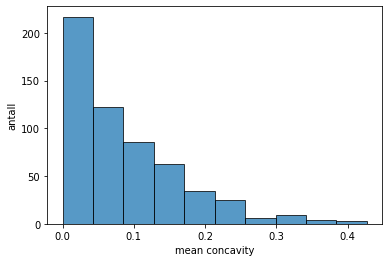

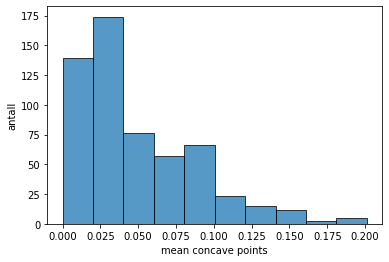

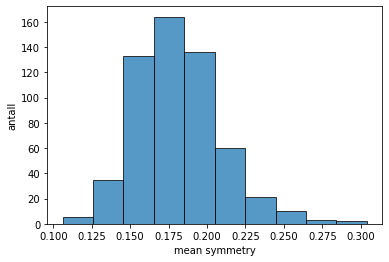

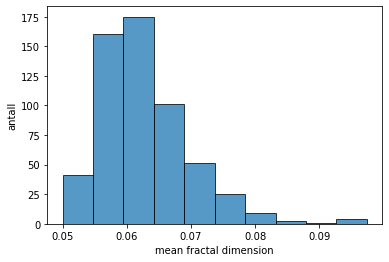

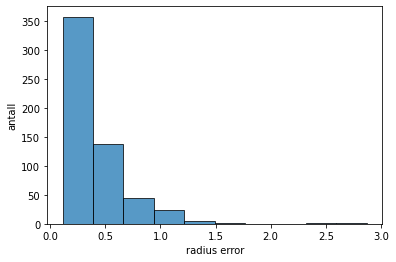

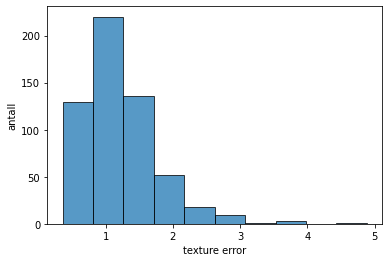

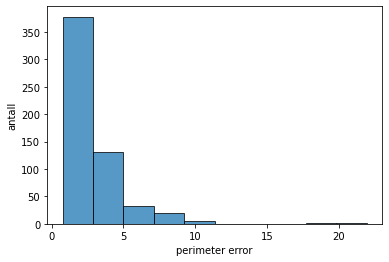

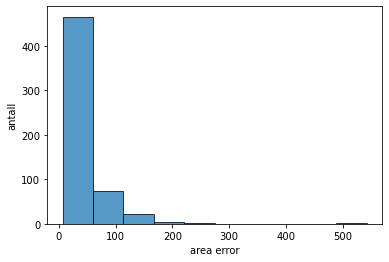

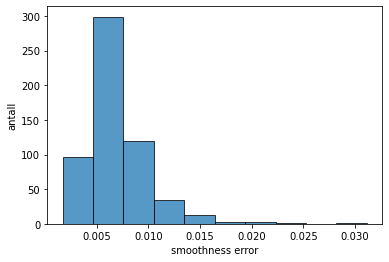

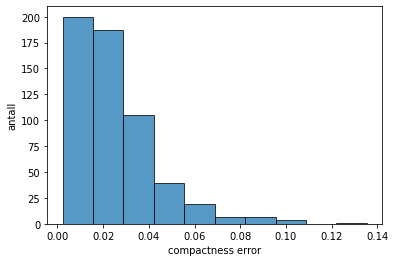

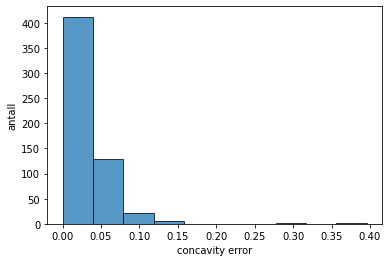

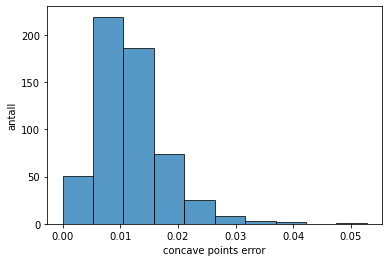

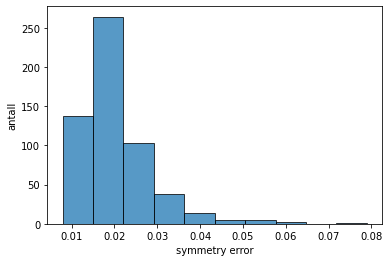

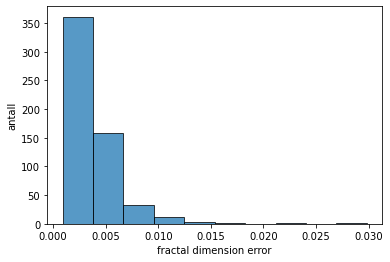

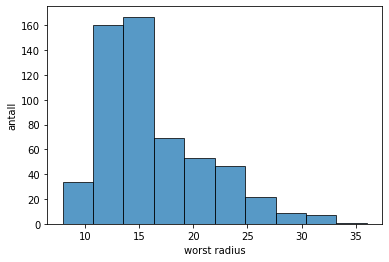

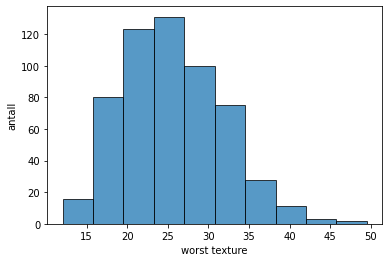

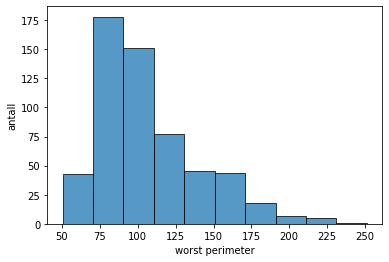

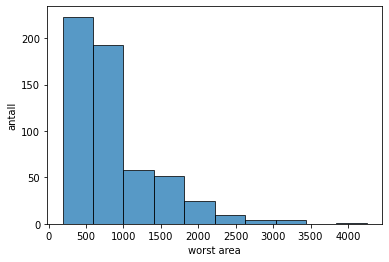

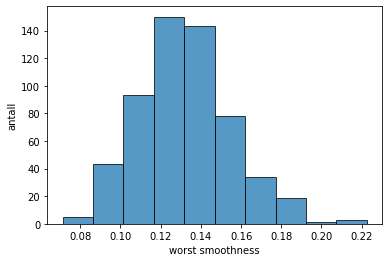

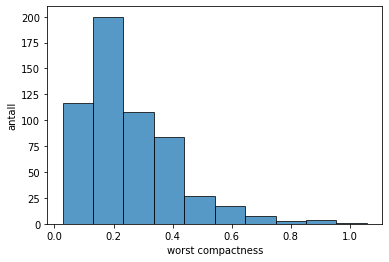

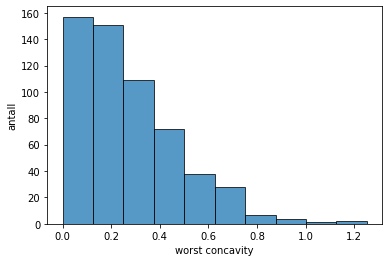

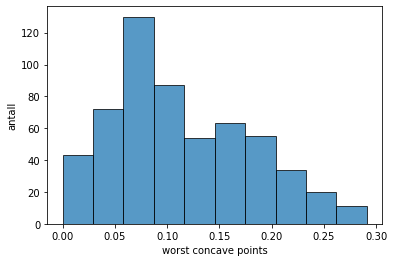

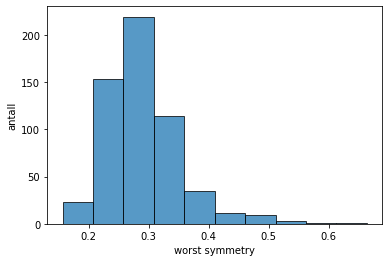

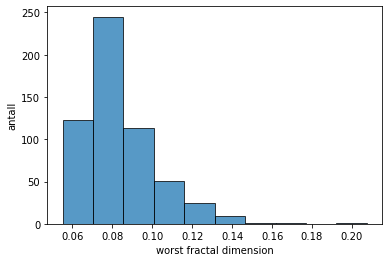

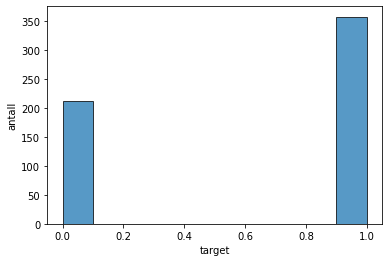

In [5]:
#Plot data to check for outliers
all_col = df.select_dtypes(include=np.number).columns.tolist()  # selecting numeric columns
for col in all_col:
    make_histogram(df, col)


### Splitte dataene
For å kunne kvantifisere modellens ytelse, splitter vi datasettet i et treningssett og et testsett. Valideringsdata er vanligvis et subsett av treningsdataene. I denne notebooken kommer vi ikke til å gjøre hyperparametertuning, så vi definerer ikke valideringsdata eksplisitt. Vi benytter scikit-learns funksjon for å splitte data. Vi må spesifisere input features (X), output features (y, target) og test_size, dvs. hvilken andel av dataene som skal brukes til test.

In [9]:
#Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.3, random_state=109) 
# test_size=0.3 corresponds to 70% training and 30% test

In [11]:
X_train

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
190,14.22,23.12,94.37,609.9,0.10750,0.24130,0.198100,0.06618,0.2384,0.07542,...,15.74,37.18,106.40,762.4,0.15330,0.93270,0.84880,0.17720,0.5166,0.14460
561,11.20,29.37,70.67,386.0,0.07449,0.03558,0.000000,0.00000,0.1060,0.05502,...,11.92,38.30,75.19,439.6,0.09267,0.05494,0.00000,0.00000,0.1566,0.05905
363,16.50,18.29,106.60,838.1,0.09686,0.08468,0.058620,0.04835,0.1495,0.05593,...,18.13,25.45,117.20,1009.0,0.13380,0.16790,0.16630,0.09123,0.2394,0.06469
493,12.46,12.83,78.83,477.3,0.07372,0.04043,0.007173,0.01149,0.1613,0.06013,...,13.19,16.36,83.24,534.0,0.09439,0.06477,0.01674,0.02680,0.2280,0.07028
89,14.64,15.24,95.77,651.9,0.11320,0.13390,0.099660,0.07064,0.2116,0.06346,...,16.34,18.24,109.40,803.6,0.12770,0.30890,0.26040,0.13970,0.3151,0.08473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,20.31,27.06,132.90,1288.0,0.10000,0.10880,0.151900,0.09333,0.1814,0.05572,...,24.33,39.16,162.30,1844.0,0.15220,0.29450,0.37880,0.16970,0.3151,0.07999
399,11.80,17.26,75.26,431.9,0.09087,0.06232,0.028530,0.01638,0.1847,0.06019,...,13.45,24.49,86.00,562.0,0.12440,0.17260,0.14490,0.05356,0.2779,0.08121
141,16.11,18.05,105.10,813.0,0.09721,0.11370,0.094470,0.05943,0.1861,0.06248,...,19.92,25.27,129.00,1233.0,0.13140,0.22360,0.28020,0.12160,0.2792,0.08158
245,10.48,19.86,66.72,337.7,0.10700,0.05971,0.048310,0.03070,0.1737,0.06440,...,11.48,29.46,73.68,402.8,0.15150,0.10260,0.11810,0.06736,0.2883,0.07748


In [12]:
X_test

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
531,11.670,20.02,75.21,416.2,0.10160,0.09453,0.042000,0.021570,0.1859,0.06461,...,13.350,28.81,87.00,550.6,0.15500,0.29640,0.27580,0.08120,0.3206,0.08950
52,11.940,18.24,75.71,437.6,0.08261,0.04751,0.019720,0.013490,0.1868,0.06110,...,13.100,21.33,83.67,527.2,0.11440,0.08906,0.09203,0.06296,0.2785,0.07408
280,19.160,26.60,126.20,1138.0,0.10200,0.14530,0.192100,0.096640,0.1902,0.06220,...,23.720,35.90,159.80,1724.0,0.17820,0.38410,0.57540,0.18720,0.3258,0.09720
256,19.550,28.77,133.60,1207.0,0.09260,0.20630,0.178400,0.114400,0.1893,0.06232,...,25.050,36.27,178.60,1926.0,0.12810,0.53290,0.42510,0.19410,0.2818,0.10050
204,12.470,18.60,81.09,481.9,0.09965,0.10580,0.080050,0.038210,0.1925,0.06373,...,14.970,24.64,96.05,677.9,0.14260,0.23780,0.26710,0.10150,0.3014,0.08750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,9.173,13.86,59.20,260.9,0.07721,0.08751,0.059880,0.021800,0.2341,0.06963,...,10.010,19.23,65.59,310.1,0.09836,0.16780,0.13970,0.05087,0.3282,0.08490
218,19.800,21.56,129.70,1230.0,0.09383,0.13060,0.127200,0.086910,0.2094,0.05581,...,25.730,28.64,170.30,2009.0,0.13530,0.32350,0.36170,0.18200,0.3070,0.08255
151,8.219,20.70,53.27,203.9,0.09405,0.13050,0.132100,0.021680,0.2222,0.08261,...,9.092,29.72,58.08,249.8,0.16300,0.43100,0.53810,0.07879,0.3322,0.14860
307,9.000,14.40,56.36,246.3,0.07005,0.03116,0.003681,0.003472,0.1788,0.06833,...,9.699,20.07,60.90,285.5,0.09861,0.05232,0.01472,0.01389,0.2991,0.07804


In [14]:
y_train

190    0
561    1
363    1
493    1
89     1
      ..
260    0
399    1
141    0
245    1
262    0
Name: target, Length: 398, dtype: int32

In [15]:
y_test

531    1
52     1
280    0
256    0
204    1
      ..
63     1
218    0
151    1
307    1
322    1
Name: target, Length: 171, dtype: int32

## Sette opp modellen, trene og predikere
For å trene modellen må vi først importere SVM-modulen og initialisere SVM-klassifiseringsobjektet med et filter (kernel) som vi tror vil passe til problemstillingen. Filteret sier noe om hvor fleksibel (wiggly) inndelingen mellom klasser kan være. Med et lineært filter kan inndelingen gjøres med rette linjer. Med andre filtre kan man oppnå buede eller sikksakkete inndelinger. Vi velger et lineært filter. Deretter tilpasser vi modellen til treningsdataene, og så predikerer vi på testdata.

_Oppgave: Svar på flervalgsspørsmål 1 (vist nedenfor) i Canvas._

1. _Hvordan fungerer en støttevektormaskin (support vector machine, SVM)?_

In [16]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for the test dataset
y_pred = clf.predict(X_test)

In [17]:
y_pred

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

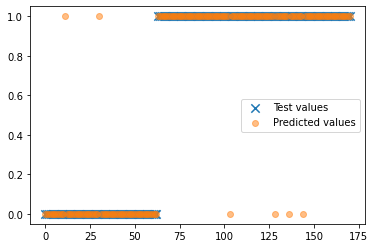

In [18]:
x = range(len(y_test))
index = np.argsort(y_test)
plt.scatter(x, y_test.iloc[index], alpha=1, marker='x', s=70, label='Test values')
plt.scatter(x, y_pred[index], alpha=0.5, label='Predicted values')
plt.legend()

In [25]:
np.argsort(y_test)

531    103
52     147
280    124
256    115
204    145
      ... 
63      61
218     58
151     57
307     79
322    170
Name: target, Length: 171, dtype: int64

Her ser vi at modellen predikerer rett klasse i de fleste tilfellene, siden de oransje sirklene ligger oppå de blå kryssene. Men det er noen tilfeller hvor modellen predikerer feil.

## Evaluering av modellen
### Nøyaktighet (accuracy)
Til å evaluere modellen kan vi benytte _nøyaktighet_ som kvantifiserer andelen av korrekt klassifiserte elementer som «antall sanne positive og sanne negative prediksjoner, dividert med antall prediksjoner».

Sann positiv = modellen predikerer at en gitt celleprøve er godartet når den faktisk er det. \
Sann negativ = modellen predikerer at en gitt celleprøve er ondartet når den faktisk er det. \
Falsk positiv = modellen predikerer at en gitt celleprøve er godartet når den faktisk er ondartet. \
Falsk negativ = modellen predikerer at en gitt celleprøve er ondartet når den faktisk er godartet. 

Det er dog et problem at definisjonen av nøyaktighet innebærer at falske positive og falske negative har samme kvalitative verdi.

La oss anta at vi hadde trent på et datasett med 100&nbsp;000 celleprøver hvorav bare 0,1&nbsp;% var ondartet. Mest sannsynlig ville modellen bare lært seg å predikere «godartet» for alle celleprøvene. Nøyaktigheten ville da bli 99,9&nbsp;%. Men den ville ikke plukke opp et eneste tilfelle med ondartet kreft. Hvis modellen i stedet hadde predikert de 0,1&nbsp;% tilfellene med ondartet kreft korrekt og 0,1 % falske positiver, ville den fortsatt ha en nøyaktighet på 99,9&nbsp;%. Sistenevnte modell er mye nyttigere enn den første modellen, men vi kan ikke skjelne mellom de to basert på nøyaktighet. Derfor trenger vi bedre evalueringskriterier.


### Presisjon og sensitivitet (precision and recall)
I stedet benytter vi _presisjon_ og _sensitivitet_. Noen steder brukes ordet «tilbakekall» om sensitivitet. Presisjon sier hvor stor andel av prediksjonene som er klassifisert som godartet (1), som faktisk er korrekt klassifisert. Og sensitivitet sier hvor stor andel av de som egentlig er godartet (1), som modellen klassifiserte korrekt.

En god modell er da karakteriseret ved både høy presisjon og høy sensitivitet.

Se gjerne den fine illustrasjon fra Wikipedia på forskjellen mellom nøyaktighet, presisjon og sensitivitet: https://en.wikipedia.org/wiki/Precision_and_recall.

In [26]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9649122807017544
Precision: 0.9811320754716981
Recall: 0.9629629629629629


_Oppgave: Svar på «Vi spør – du svarer»-spørsmål 1 (vist nedenfor) i Canvas._

1. _Er dette en bra modell?_